# Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim
from sklearn.model_selection import train_test_split
import re

# Загрузка и обработка текста


In [2]:
with open('train.txt', 'r', encoding='UTF-8') as file:
    text = file.read().lower()
    text = re.sub(r"[^А-я ' ']",'', text)
print(text[:50])

раскольников не привык к толпе и как уже сказано б


# Создание тестовой и обучающей выборок


In [3]:
num_chars = 5
char_list = list(text)

x = np.array([char_list[i:i+num_chars] for i in range(len(char_list) - num_chars - 1)])
y = np.array([char_list[i+num_chars] for i in range(len(char_list) - num_chars - 1)])

y = np.expand_dims(y, 1)
y.reshape(-1, 1)
print(y.shape)
# data = np.array([(x, y) for x, y in zip(x, y)])
print(len(x), len(y))
data = np.concatenate((x, y), axis=1)
print(data.shape)

(82276, 1)
82276 82276
(82276, 6)


In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
test_data.shape, train_data.shape

((16456, 6), (65820, 6))

In [5]:
# создадим словарь из уникальных символов выборки
vocab = set(char_list)
vocab_size = len(vocab)
print(len(vocab))
char2idx = {char: idx for idx, char in enumerate(vocab, 1)}
idx2char = list(vocab)
print(char2idx)
print(idx2char)

33
{'я': 1, 'о': 2, 'к': 3, 'п': 4, ' ': 5, 'р': 6, 'б': 7, 'ф': 8, 'м': 9, 'ч': 10, 'л': 11, 'щ': 12, 'ъ': 13, 'д': 14, 'з': 15, 'у': 16, 'в': 17, 'е': 18, 'а': 19, 'ь': 20, 'с': 21, 'н': 22, 'и': 23, 'ш': 24, 'й': 25, 'х': 26, 'э': 27, 'ц': 28, 'г': 29, 'ю': 30, 'т': 31, 'ж': 32, 'ы': 33}
['я', 'о', 'к', 'п', ' ', 'р', 'б', 'ф', 'м', 'ч', 'л', 'щ', 'ъ', 'д', 'з', 'у', 'в', 'е', 'а', 'ь', 'с', 'н', 'и', 'ш', 'й', 'х', 'э', 'ц', 'г', 'ю', 'т', 'ж', 'ы']


In [6]:
def encoder_text(text):
    encoding = []
    for word in text:
        encoding.append([char2idx[char] for char in word])
    return encoding

train_data = np.array([encoder_text(data) for data in train_data[:, :,]])
test_data = np.array([encoder_text(data) for data in test_data[:, :,]])

In [7]:
train_data.shape

(65820, 6, 1)

In [8]:
print(test_data[1, : -1])
print(test_data[0, -1])

[[18]
 [32]
 [14]
 [18]
 [ 5]]
[2]


In [9]:
# Создание датасета и загрузчика
class CharPredictDataset(Dataset):
    def __init__(self, data):
        self.inputs = data[:, :-1]
        self.labels = data[:, -1]
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input = self.inputs[idx]
        label = self.labels[idx]
        return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.long)
    

In [10]:
train_dataset = CharPredictDataset(train_data)
test_dataset = CharPredictDataset(test_data)

In [11]:
print(len(train_dataset), train_dataset[0])


65820 (tensor([[ 1],
        [23],
        [22],
        [ 5],
        [ 5]]), tensor([22]))


In [166]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [167]:
x = next(iter(test_loader))

In [168]:
print(x[0].shape)
print(x[1].shape)


torch.Size([3, 5, 1])
torch.Size([3, 1])


# Построение модели RNN

In [169]:
class CharPredictRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True, num_layers=4, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        #h0 = torch.zeros(1, x.size(0), self.hidden_size)
        x = self.emb(x.reshape(x.shape[0], x.shape[1]))
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [170]:
# hyperparameters
vocab_size = len(vocab) +1
embed_size = 80
hidden_size = 80
output_size = vocab_size

In [171]:
model = CharPredictRNN(vocab_size, embed_size, hidden_size, output_size)

In [172]:
print(model)

CharPredictRNN(
  (emb): Embedding(34, 80)
  (rnn): LSTM(80, 80, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=160, out_features=34, bias=True)
)


In [173]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0006)

In [174]:
x = next(iter(train_loader))
input = x[0]
res = model(x[0])
label = x[1].reshape(batch_size)
print(input.shape, res.shape, label.shape)

torch.Size([3, 5, 1]) torch.Size([3, 34]) torch.Size([3])


In [175]:
criterion(res, label)

tensor(3.5778, grad_fn=<NllLossBackward0>)

In [176]:
# Training..
max_epoch = 150
total_loss = []
for epoch in range(max_epoch):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        labels = labels.reshape(batch_size)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    total_loss.append(epoch_loss /  len(train_loader))
    print(f"Epoch[{epoch + 1}/{max_epoch}], Loss: {epoch_loss / len(train_loader)}")
        

KeyboardInterrupt: 

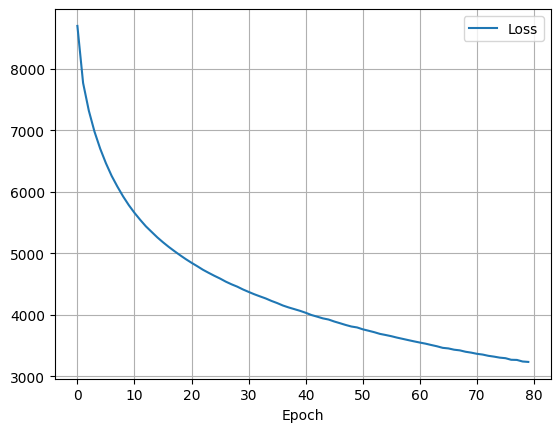

In [106]:
plt.plot(total_loss)
plt.xlabel('Epoch')
plt.legend(['Loss'])
plt.grid()
plt.show()

In [107]:
# Testing
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        result = model(inputs)
        predict = torch.argmax(result, dim=1)
        total += len(labels)
        correct += sum([all(labels[i] == predict[i]) for i in range(len(labels))])


In [108]:
print(total)
print(correct)
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

16456
7997
Accuracy: 48.60%


In [165]:
def get_str(inp_str, len_str=300):
    model.eval()
    for i in range(len_str):
        x = []
        for j in range(i, i + 5):
            x.append(*encoder_text(inp_str[j]))
            
        x = torch.tensor(x).reshape(-1, 5)
        output = model(x)
        
        predict = output[0].detach()
        predict = torch.tensor(predict)
        predict[predict < 0] = 0
        predict /= len(predict)
        predict[predict <= 0.009] = 0
        predict = torch.multinomial(predict, 1)
        char = idx2char[predict - 1]
        inp_str += char
    return inp_str

print(get_str('когда'))

C:\Users\Denis\AppData\Local\Temp\ipykernel_11100\1474730223.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict = torch.tensor(predict)


когда букную о тотчывтам мное ниглягда взвише ахупулсяти и кошии  о песлия можененыт всю езьгою булжыйды такую питеническорвояскордый и нус твломиезда и уейто пите слюшсей кажитыйны чекрацщившийшего двлыйшемнегую казщиексойкатьи рублечимогчато вырво она стутвожну и васию извующннавбедст кольникегаходышат


In [121]:
a = torch.tensor([20, 0.8])

In [124]:
torch.multinomial(a, 1)

tensor([0])